In [30]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fairface/FairFace/val_labels.csv
/kaggle/input/fairface/FairFace/train_labels.csv
/kaggle/input/fairface/FairFace/val/7981.jpg
/kaggle/input/fairface/FairFace/val/6234.jpg
/kaggle/input/fairface/FairFace/val/1269.jpg
/kaggle/input/fairface/FairFace/val/3863.jpg
/kaggle/input/fairface/FairFace/val/6241.jpg
/kaggle/input/fairface/FairFace/val/10304.jpg
/kaggle/input/fairface/FairFace/val/623.jpg
/kaggle/input/fairface/FairFace/val/2193.jpg
/kaggle/input/fairface/FairFace/val/3750.jpg
/kaggle/input/fairface/FairFace/val/2008.jpg
/kaggle/input/fairface/FairFace/val/10730.jpg
/kaggle/input/fairface/FairFace/val/5982.jpg
/kaggle/input/fairface/FairFace/val/7737.jpg
/kaggle/input/fairface/FairFace/val/2081.jpg
/kaggle/input/fairface/FairFace/val/10597.jpg
/kaggle/input/fairface/FairFace/val/6588.jpg
/kaggle/input/fairface/FairFace/val/10054.jpg
/kaggle/input/fairface/FairFace/val/7966.jpg
/kaggle/input/fairface/FairFace/val/3919.jpg
/kaggle/input/fairface/FairFace/val/6197.jpg
/

In [1]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, models, datasets
from torchinfo import summary

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
import cv2
from PIL import Image
import glob
from datetime import datetime
import pytz
import time
import os
from tqdm import tqdm
import random
import gc

%matplotlib inline

print("Imports done!")

Imports done!


In [32]:
path = "/kaggle/input/fairface/FairFace/"
train_df = pd.read_csv(os.path.join(path, "train_labels.csv"))
valid_df = pd.read_csv(os.path.join(path, "val_labels.csv"))

In [33]:
train_df.head()

file    age  gender        race  service_test
0  train/1.jpg  50-59    Male  East Asian          True
1  train/2.jpg  30-39  Female      Indian         False
2  train/3.jpg    3-9  Female       Black         False
3  train/4.jpg  20-29  Female      Indian          True
4  train/5.jpg  20-29  Female      Indian          True

In [34]:
train_df.shape

(86744, 5)

In [35]:
valid_df.head()

file    age  gender             race  service_test
0  val/1.jpg    3-9    Male       East Asian         False
1  val/2.jpg  50-59  Female       East Asian          True
2  val/3.jpg  30-39    Male            White          True
3  val/4.jpg  20-29  Female  Latino_Hispanic          True
4  val/5.jpg  20-29    Male  Southeast Asian         False

In [36]:
valid_df.shape

(10954, 5)

In [37]:
sorted(train_df.age.unique())

['0-2',
 '10-19',
 '20-29',
 '3-9',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 'more than 70']

In [38]:
sorted(valid_df.age.unique())

['0-2',
 '10-19',
 '20-29',
 '3-9',
 '30-39',
 '40-49',
 '50-59',
 '60-69',
 'more than 70']

Thus, this is a multi-class classification problem with 9 classes.

## Approach

We will only use the images to estimate the age interval. We will discard other features like `gender`, `race`, and `service_test`.

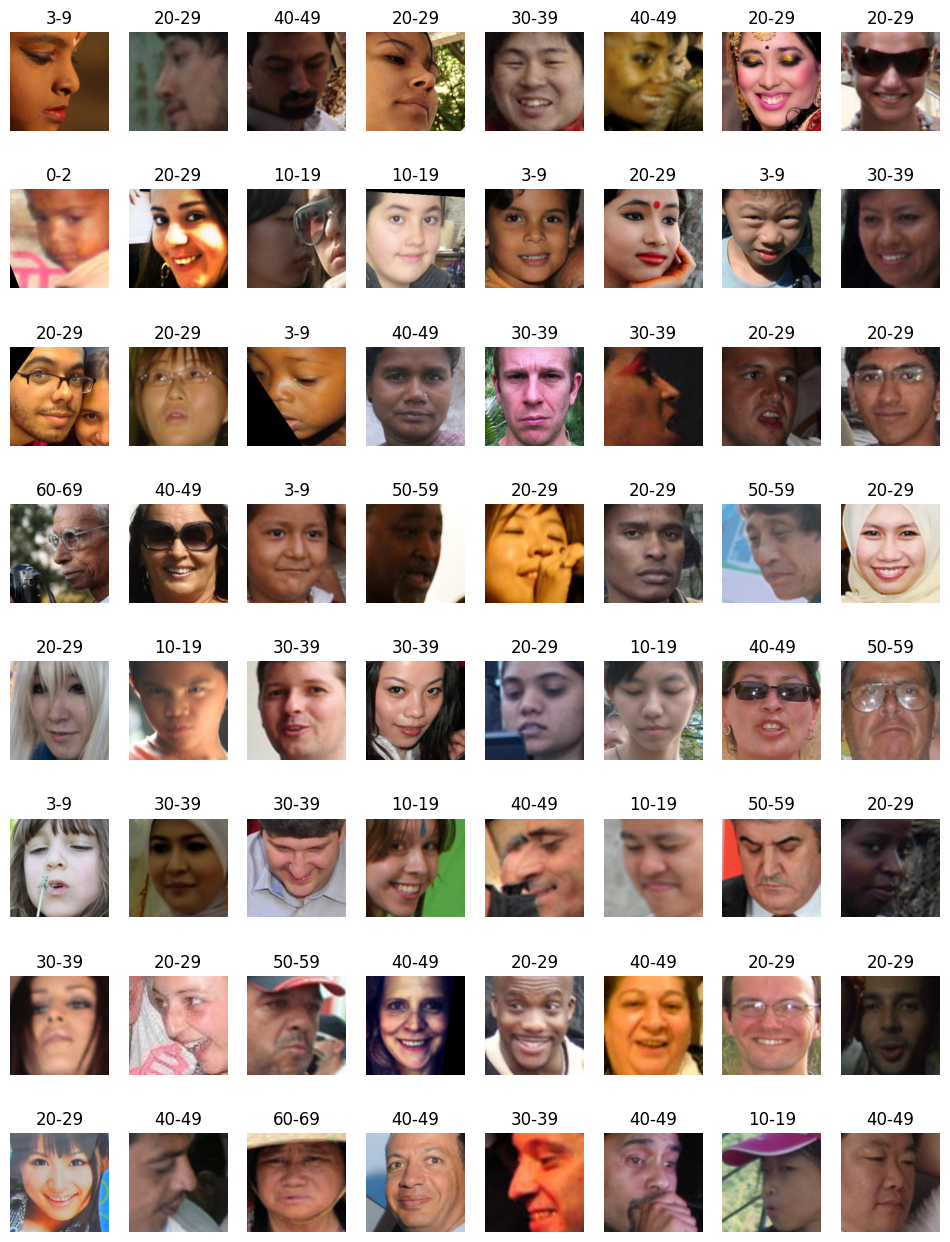

In [39]:
def visualize_data():
    nrows, ncols = 8, 8
    indices = np.random.randint(low=0, high=len(train_df), 
                                size=nrows*ncols).reshape(nrows, ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12,16))
    for i in range(nrows):
        for j in range(ncols):
            idx = indices[i][j]
            img_name = f"train/{idx}.jpg"
            age_value = train_df[train_df["file"] == img_name].age.item()
            img_file = os.path.join(path, img_name)
            img = Image.open(img_file)
            img_arr = np.array(img.convert("RGB"))
            ax[i,j].imshow(img_arr)
            ax[i,j].set_title(age_value, fontsize=12)
            ax[i,j].axis("off")
    
    
visualize_data()

In [40]:
gc.collect()

142685

In [41]:
train_df2 = train_df.copy()
train_df2 = train_df2.drop(["gender", "race", "service_test"], axis=1)
valid_df2 = valid_df.copy()
valid_df2 = valid_df2.drop(["gender", "race", "service_test"], axis=1)

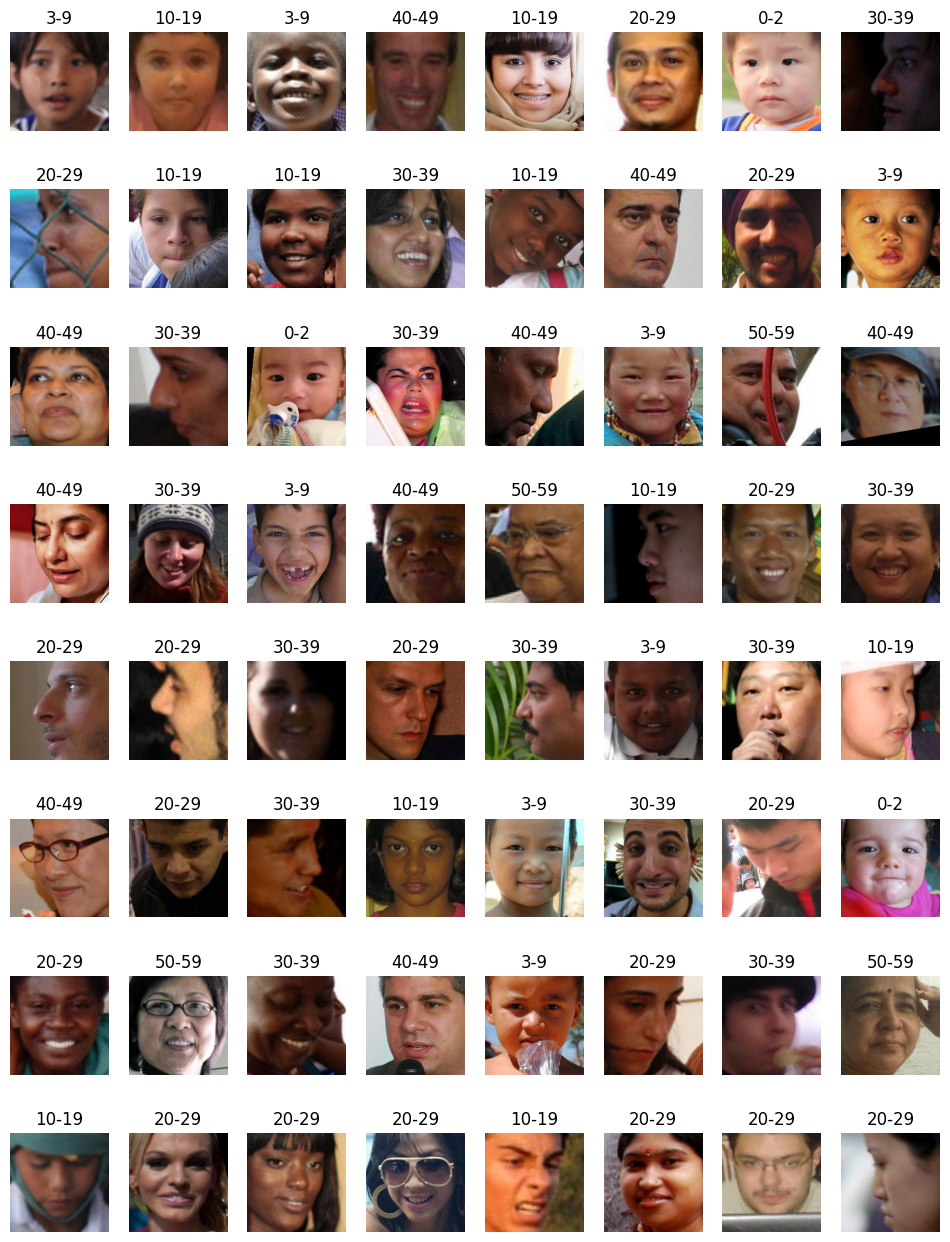

In [42]:
def visualize_data():
    nrows, ncols = 8, 8
    indices = np.random.randint(low=0, high=len(valid_df2), 
                                size=nrows*ncols).reshape(nrows, ncols)
    fig, ax = plt.subplots(nrows, ncols, figsize=(12,16))
    for i in range(nrows):
        for j in range(ncols):
            idx = indices[i][j]
            img_name = f"val/{idx}.jpg"
            age_value = valid_df2[valid_df2["file"] == img_name].age.item()
            img_file = os.path.join(path, img_name)
            img = Image.open(img_file)
            img_arr = np.array(img.convert("RGB"))
            ax[i,j].imshow(img_arr)
            ax[i,j].set_title(age_value, fontsize=12)
            ax[i,j].axis("off")
    
    
visualize_data()

In [43]:
# Label Encoding
le = LabelEncoder()
train_df2.age = le.fit_transform(train_df2.age)
valid_df2.age = le.transform(valid_df2.age)

In [44]:
train_df2.head()

file  age
0  train/1.jpg    6
1  train/2.jpg    4
2  train/3.jpg    3
3  train/4.jpg    2
4  train/5.jpg    2

In [45]:
le.classes_

array(['0-2', '10-19', '20-29', '3-9', '30-39', '40-49', '50-59', '60-69',
       'more than 70'], dtype=object)

In [46]:
le.inverse_transform(train_df2.age[:5])

array(['50-59', '30-39', '3-9', '20-29', '20-29'], dtype=object)

In [47]:
classes = {
    0: '0-2',
    1: '10-19',
    2: '20-29', 
    3: '3-9',
    4: '30-39', 
    5: '40-49', 
    6: '50-59', 
    7: '60-69',
    8: 'more than 70'
}

In [2]:
class DivideBy(nn.Module):
    def __init__(self, factor):
        self.factor = factor

    def __call__(self, tensor):
        return tensor / self.factor
    
    

In [19]:
aug = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    DivideBy(255.0)  
])

a = np.random.randn(3, 3, 3)

aug(a)

tensor([[[-0.0306, -0.0157,  0.0072],
         [ 0.0118, -0.0202, -0.0391],
         [-0.0195, -0.0195, -0.0076]],

        [[-0.0280, -0.0246, -0.0229],
         [-0.0211, -0.0130, -0.0048],
         [ 0.0054,  0.0045, -0.0044]],

        [[-0.0166, -0.0141, -0.0091],
         [ 0.0057, -0.0035, -0.0264],
         [-0.0143, -0.0333, -0.0007]]], dtype=torch.float64)

In [7]:
IMAGE_SIZE = 224

class AgeClass(Dataset):
    def __init__(self, df, path, tfms=None):
        self.df = df
        self.path = path
        self.normalize = transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            DivideBy(255.0)  
        ])
        
    def __len__(self): 
        return len(self.df)
    
    def preprocess_image(self, img, IMAGE_SIZE=224):
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
        img = torch.tensor(img).permute(2,0,1)
        img = self.normalize(img)
        # Using None for indexing is a fancy way of unsqueezing, ie,
        # img[None] is equivalent to img.unsqueeze(dim=0)
        return img[None]
    
    def __getitem__(self, ix, IMAGE_SIZE=224):
        f = self.df.iloc[ix].squeeze()
        file = os.path.join(self.path, f.file)
        age = f.age
        img = cv2.imread(file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img, age

    def collate_fn(self, batch):
        'preprocess images and ages'
        images, ages = [], []
        for img, age in batch:
            img = self.preprocess_image(img)
            images.append(img)
            ages.append(age)
        ages = torch.tensor(ages)
        images = torch.cat(images)
        return images, ages
    

In [49]:
train_dataset = AgeClass(train_df2, "/kaggle/input/fairface/FairFace")
valid_dataset = AgeClass(valid_df2, "/kaggle/input/fairface/FairFace")

In [50]:
train_dataset[0][0].shape

(224, 224, 3)

In [51]:
def fn():
    img = train_dataset[0][0]
    return train_dataset.preprocess_image(img).shape

fn()

torch.Size([1, 3, 224, 224])

In [52]:
batchsize = 32
train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True,
                          collate_fn=train_dataset.collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False,
                          collate_fn=valid_dataset.collate_fn)

# train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, drop_last=True)
# valid_loader = DataLoader(valid_dataset, batch_size=batchsize, shuffle=False)

In [53]:
def fn():
    for X,y in train_loader:
        print(X.shape)
        print(y.shape)
        return "successfully executed"
    
fn()

torch.Size([32, 3, 224, 224])
torch.Size([32])


'successfully executed'

In [54]:
def get_torch_version():
    torch_version = torch.__version__.split("+")[0]
    torch_number = torch_version.split(".")[:2]
    torch_number_float = torch_number[0] + "." + torch_number[1]
    torch_number_float = float(torch_number_float)
    return torch_number_float


def set_seed(seed=42):
    """
    Seeds basic parameters for reproducibility of results
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True
        if get_torch_version() <= 1.7:
            torch.set_deterministic(True)
        else:
            torch.use_deterministic_algorithms(True)
    

def compute_accuracy(y_pred, y):
    assert len(y_pred)==len(y), "length of y_pred and y must be equal"
    acc = torch.eq(y_pred, y).sum().item()
    acc = acc/len(y_pred)
    return acc


def train_validation_split(train_dataset):
    X_train, X_valid, y_train, y_valid = train_test_split(train_dataset.data, train_dataset.targets, 
                                                          test_size=0.2, random_state=42, shuffle=True, 
                                                          stratify=train_dataset.targets)
    X_train = torch.tensor(X_train, dtype=torch.float64).permute(0, 3, 1, 2)
    X_valid = torch.tensor(X_valid, dtype=torch.float64).permute(0, 3, 1, 2)
    y_train = torch.tensor(y_train, dtype=torch.int64)
    y_valid = torch.tensor(y_valid, dtype=torch.int64)
    return X_train, X_valid, y_train, y_valid
    

def predict(model, img_path, device):
    img = cv2.imread(img_path)
    if img.shape[-1] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
    img2 = img.copy()
    img = torch.tensor(img)
    img = img.permute(1,2,0)
    img = img.unsqueeze(dim=0)
    img = img.to(device)
    model.eval()
    with torch.inference_mode():
        logit = model(img)
    pred_prob = torch.softmax(logit, dim=1)
    pred_label = pred_prob.argmax(dim=1)
    plt.imshow(img2)
    plt.axis("off")
    plt.label(f"Prediction: {classes[pred_label]}\t\tProbability: {round(pred_prob)}")
    plt.show()


def set_scheduler(scheduler, results, scheduler_on):
    """Makes the neccessary updates to the scheduler."""
    if scheduler_on == "val_acc":
        scheduler.step(results["val_acc"][-1])
    elif scheduler_on == "val_loss":
        scheduler.step(results["val_loss"][-1])
    elif scheduler_on == "train_acc":
        scheduler.step(results["train_acc"][-1])
    elif scheduler_on == "train_loss":
        scheduler.step(results["train_loss"][-1])
    else:
        raise ValueError("Invalid `scheduler_on` choice.")
    return scheduler


def visualize_results(results):
    """Plot the training and validation loss and accuracy, given the results dictionary"""
    train_loss, train_acc = results["train_loss"], results["train_acc"]
    val_loss, val_acc = results["valid_loss"], results["valid_acc"]
    x = np.arange(len(train_loss))  # this is the number of epochs
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
    # ax[0].set_title("Loss")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Loss")
    ax[0].plot(x, train_loss, label="train_loss", color="orange")
    ax[0].plot(x, val_loss, label="valid_loss", color="blue")
    ax[0].legend()
    # ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Accuracy")
    ax[1].plot(x, train_acc, label="train_acc", color="orange")
    ax[1].plot(x, val_acc, label="valid_acc", color="blue")
    ax[1].legend()
    plt.show()
    

def train_step(model, loss_fn, optimizer, dataloader, device):
    model.train()
    train_loss = 0
    train_acc = 0
    for X,y in dataloader:
        X = X.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        logit = model(X)
        pred_prob = torch.softmax(logit, dim=1)
        pred_label = pred_prob.argmax(dim=1)
        # note: first put logit and then y in the loss_fn
        # otherwise, if you put y first and then logit, then it will raise an error
        loss = loss_fn(logit, y)   
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        acc = compute_accuracy(pred_label, y)
        train_acc += acc
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc
        

def valid_step(model, loss_fn, dataloader, device):
    model.eval()
    valid_loss = 0
    valid_acc = 0
    model.eval()
    with torch.inference_mode():
        for X,y in dataloader:
            X = X.to(device)
            y = y.to(device)
            logit = model(X)
            pred_prob = torch.softmax(logit, dim=1)
            pred_label = pred_prob.argmax(dim=1)
            # note: first put logit and then y in the loss_fn
            # otherwise, if you put y first and then logit, then it will raise an error
            loss = loss_fn(logit, y)
            valid_loss += loss.item()
            acc = compute_accuracy(pred_label, y)
            valid_acc += acc
    valid_loss = valid_loss / len(dataloader)
    valid_acc = valid_acc / len(dataloader)
    return valid_loss, valid_acc


def training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                 epochs, scheduler=None, scheduler_on="val_acc", verbose=False):
    """
    Does model training and validation for one fold in a k-fold cross validation setting.
    """
    results = {
        "train_loss": [],
        "train_acc": [],
        "valid_loss": [],
        "valid_acc": []
    }
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model, loss_fn, optimizer, train_dataloader, device)
        valid_loss, valid_acc = valid_step(model, loss_fn, valid_dataloader, device)
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["valid_loss"].append(valid_loss)
        results["valid_acc"].append(valid_acc)
        if verbose: 
            print(
                    f"Epoch: {epoch+1} | Train_loss: {train_loss:.5f} | "
                    f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                    f"Val_acc: {valid_acc:.5f}"
                )
        if scheduler is not None:
            scheduler = set_scheduler(scheduler, results, scheduler_on)
    visualize_results(results)


def training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, 
                 scheduler=None, scheduler_on="val_acc", verbose=False, n_splits=5):
    """
    Does the training and validation for all the folds in a k-fold cross validation setting.
    """
    kf = StratifiedKFold(n_splits=n_splits, random_state=42, shuffle=True)
    MODELS = []
    for fold, (train_idx, val_idx) in enumerate(kf.split(X=train_dataset.data, y=train_dataset.targets)):
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(train_idx))
        valid_dataloader = DataLoader(dataset=train_dataset, batch_size=64, 
                                      sampler=SubsetRandomSampler(val_idx))
        results = training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, 
                                epochs, scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
        train_loss = np.mean(results["train_loss"])
        valid_loss = np.mean(results["valid_loss"])
        train_acc = np.mean(results["train_acc"])
        valid_acc = np.mean(results["valid_acc"])
        print(
                f"Fold: {fold+1} | Train_loss: {train_loss:.5f} | "
                f"Train_acc: {train_acc:.5f} | Val_loss: {valid_loss:.5f} | "
                f"Val_acc: {valid_acc:.5f}"
            )
        visualize_results(results)
        MODELS.append(model)
    return MODELS


def training_function(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=None, 
                      scheduler_on="val_acc", verbose=False, validation_strategy="train test split",
                      n_splits=5):
    """
    validation_strategy: choose either "train test split" or "k-fold cross validation"
    """
    if validation_strategy == "train test split":
        X_train, X_valid, y_train, y_valid = train_validation_split(train_dataset)
        train_dataset = CustomDataset(features=X_train, targets=y_train)
        valid_dataset = CustomDataset(features=X_valid, targets=y_valid)
        train_dataloader = DataLoader(dataset=train_dataset, batch_size=CONFIG["batchsize"], shuffle=True)
        valid_dataloader = DataLoader(dataset=valid_dataset, batch_size=CONFIG["batchsize"], shuffle=False)
        training_fn1(model, loss_fn, optimizer, train_dataloader, valid_dataloader, device, epochs, 
                     scheduler=scheduler, scheduler_on=scheduler_on, verbose=verbose)
    elif validation_strategy == "k-fold cross validation":
        training_fn2(model, loss_fn, optimizer, train_dataset, device, epochs, scheduler=scheduler, 
                     scheduler_on=scheduler_on, verbose=verbose, n_splits=n_splits)
    else:
        raise ValueError("Invalid validation strategy.\nChoose either \"train test split\" \
        or \"k-fold cross validation\"")

    
def save_model_info(path: str, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    # A good practice is to transfer the model to the CPU before calling torch.save as this 
    # will save tensors as CPU tensors and not as CUDA tensors. This will help in loading
    # the model onto any machine, whether it contains CUDA capabilities or not.
    model.to("cpu")
    torch.save(model.state_dict(), os.path.join(path,model_name))
    torch.save(optimizer.state_dict(), os.path.join(path,optimizer_name))
    if scheduler is not None:
        torch.save(scheduler.state_dict(), os.path.join(path,scheduler_name))    
    print("Model info saved!")
    
    
def load_model_info(PATH, device, model, model_name, optimizer, optimizer_name, 
                    scheduler=None, scheduler_name=""):
    model.load_state_dict(torch.load(os.path.join(path,model_name)))
    model.to(device)
    optimizer.load_state_dict(torch.load(os.path.join(path,optimizer_name)))
    if scheduler is not None:
        scheduler.load_state_dict(torch.load(os.path.join(path,scheduler_name)))
    print("Model info loaded!")
    
    
def get_current_time():
    """Returns the current time in Toronto."""
    now = datetime.now(pytz.timezone('Canada/Eastern'))
    current_time = now.strftime("%d_%m_%Y__%H_%M_%S")
    return current_time


print("Utility functions created!")

Utility functions created!


In [ ]:
class Model1(nn.Module):
    def __init__(self):
        super(Model1, self).__init__()
        weights = torchvision.models.VGG16_Weights.DEFAULT
        self.backbone = torchvision.models.vgg16(weights=weights)
        for param in self.backbone.parameters():
            param.requires_grad = False
        self.backbone.avgpool = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.Flatten()
        )
        self.backbone.classifier = nn.Sequential(
            nn.Linear(2048,512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64, 10),
        )
        
    def forward(self, x):
        x = self.backbone(x)
        return x
    

In [ ]:
summary(model=Model1(), input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

In [ ]:
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"
model1 = Model1().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model1.parameters(), lr=1e-4)

In [ ]:
training_fn1(model1, loss_fn, optimizer, train_loader, valid_loader, device, epochs, verbose=True)

In [ ]:
curr_time = get_current_time()
curr_time

In [ ]:
path = os.path.join(os.getcwd(), curr_time)
os.makedirs(path, exist_ok=True)

print(path)

In [ ]:
model_name = "Model1_1.pt"
optimizer_name = "Adam_1.pt"

save_model_info(path, device, model1, model_name, optimizer, optimizer_name)

In [ ]:
path = "/kaggle/working/31_08_2024__19_23_02"
loaded_model1 = Model1().to(device)
loaded_optimizer1 = optim.Adam(params=loaded_model1.parameters(), lr=3e-4, weight_decay=0.005)
load_model_info(path, device, loaded_model1, model_name, loaded_optimizer1, optimizer_name)

In [ ]:
def fn(idx=0):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    img = valid_dataset[idx][0]
    age = classes[valid_dataset[idx][1]]
    print(img.shape)
    print(age)
    img_tensor = valid_dataset.preprocess_image(img)
    print(img_tensor.shape)
    loaded_model1.eval()
    with torch.inference_mode():
        img_tensor = img_tensor.to(device)
        # assuming model is already on the correct device
        output = loaded_model1(img_tensor)
        pred_prob = torch.softmax(output, dim=1)
        pred_label = classes[pred_prob.argmax(dim=1).cpu().detach().numpy().item()]
        label_prob = torch.max(pred_prob) * 100
    plt.imshow(img)
    plt.title(f"Prediction: {pred_label}\nActual: {age}\nProbability: {label_prob:.1f}%")


fn(10)

In [61]:
class Model2(nn.Module):
    def __init__(self):
        super(Model2, self).__init__()
        
        weights = torchvision.models.EfficientNet_B3_Weights.DEFAULT
        model = torchvision.models.efficientnet_b3(weights=weights)
        for param in model.parameters():
            param.requires_grad = False
        self.backbone = model
        self.classifierhead = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 9)
        )
    
    def forward(self, x):
        x = self.backbone(x)
        x = self.classifierhead(x)
        return x
    
    
    
model2 = Model2()

In [62]:
summary(model=model2, input_size=(1,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20, row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
Model2 (Model2)                                                   [1, 3, 224, 224]     [1, 9]               --                   Partial
├─EfficientNet (backbone)                                         [1, 3, 224, 224]     [1, 1000]            --                   False
│    └─Sequential (features)                                      [1, 3, 224, 224]     [1, 1536, 7, 7]      --                   False
│    │    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 40, 112, 112]    (1,160)              False
│    │    └─Sequential (1)                                        [1, 40, 112, 112]    [1, 24, 112, 112]    (3,504)              False
│    │    └─Sequential (2)                                        [1, 24, 112, 112]    [1, 32, 56, 56]      (48,118)             False
│    │    └─Sequential (3)                       

In [64]:
epochs = 10
device = "cuda" if torch.cuda.is_available() else "cpu"
model2 = Model2().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model2.parameters(), lr=0.1e-4)

In [65]:
training_fn1(model2, loss_fn, optimizer, train_loader, valid_loader, device, epochs, verbose=True)

 10%|█         | 1/10 [06:33<58:58, 393.17s/it]

Epoch: 1 | Train_loss: 1.99945 | Train_acc: 0.25078 | Val_loss: 2.37554 | Val_acc: 0.31409


 20%|██        | 2/10 [13:01<52:02, 390.37s/it]

Epoch: 2 | Train_loss: 1.80619 | Train_acc: 0.30858 | Val_loss: 1.99705 | Val_acc: 0.32657


 30%|███       | 3/10 [19:31<45:29, 389.96s/it]

Epoch: 3 | Train_loss: 1.75194 | Train_acc: 0.31666 | Val_loss: 1.87212 | Val_acc: 0.33622


 40%|████      | 4/10 [25:53<38:41, 386.90s/it]

Epoch: 4 | Train_loss: 1.72915 | Train_acc: 0.32274 | Val_loss: 2.25565 | Val_acc: 0.33786


 50%|█████     | 5/10 [32:16<32:08, 385.70s/it]

Epoch: 5 | Train_loss: 1.71621 | Train_acc: 0.32357 | Val_loss: 1.69948 | Val_acc: 0.33858


 50%|█████     | 5/10 [36:27<36:27, 437.47s/it]


KeyboardInterrupt: 

In [ ]:
curr_time = get_current_time()
curr_time

In [ ]:
path = os.path.join(os.getcwd(), curr_time)
os.makedirs(path, exist_ok=True)

print(path)

In [ ]:
model_name = "Model2_1.pt"
optimizer_name = "Adam_2.pt"

save_model_info(path, device, model2, model_name, optimizer, optimizer_name)

In [ ]:
path = "/kaggle/working/"
loaded_model2 = Model2().to(device)
loaded_optimizer2 = optim.Adam(params=loaded_model2.parameters(), lr=3e-4, weight_decay=0.005)
load_model_info(path, device, loaded_model2, model_name, loaded_optimizer2, optimizer_name)

In [ ]:
def fn(idx=0):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    img = valid_dataset[idx][0]
    age = classes[valid_dataset[idx][1]]
    print(img.shape)
    print(age)
    img_tensor = valid_dataset.preprocess_image(img)
    print(img_tensor.shape)
    loaded_model2.eval()
    with torch.inference_mode():
        img_tensor = img_tensor.to(device)
        # assuming model is already on the correct device
        output = loaded_model2(img_tensor)
        pred_prob = torch.softmax(output, dim=1)
        pred_label = classes[pred_prob.argmax(dim=1).cpu().detach().numpy().item()]
        label_prob = torch.max(pred_prob) * 100
    plt.imshow(img)
    plt.title(f"Prediction: {pred_label}\nActual: {age}\nProbability: {label_prob:.1f}%")


fn(10)

In [ ]:
gc.collect()